# Projet Mathématiques/Informatique : lignes de niveau
## Alex Morais Penso - Juliette Montantème

## Contour simple

### Amorce

$f$ étant une fonction continûment différentiable, en appliquant le théorème des valeurs intermédiaires à la fonction $g : x \mapsto f(0,x) $ définie sur $[0,1]$ , on peut trouver une condition raisonnable pour être certain qu'il existe un $t \in [0,1]$ tel que $f(0,t) = c$. 

Cette condition est : $ min(f(0,0), f(0,1)) \leq c \leq max(f(0,0), f(0,1))$

Pour écrire la fonction `find_seed` , on va d'abord vérifier que l'on se trouve dans le cadre de la condtion évoquée précedemment. Puis, le cas échéant, on utilise une méthode par dichotomie, qui, étant donné un $c$, permet de trouver rapidement un $t$ (à eps près) satisfaisant la condition $f(0,t) = c$. Sinon, la fonction renvoie $None$.

In [47]:
#on réalise les importations nécessaires à toute la suite de l'exercice

import math
import autograd
from autograd import numpy as np
from autograd import grad
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
def find_seed(g, c=0, eps=2**(-26)):
    
    """on réalise un premier test pour savoir si la première condition est respectée"""
    
    if min(g(0,0), g(0,1)) <= c <= max(g(0,0), g(0,1)):
        a = 0
        b = 1
        while abs(g(0,(a+b)/2)-c) > eps:
            
            """cette boucle permet de restreindre le segment de recherche
            en appliquant à chaque fois le processus de départ"""
            
            if min(g(0,a), g(0,(a+b)/2)) <= c <= max(g(0,(a+b)/2), g(0,a)):
                b = (a+b)/2
            else :
                a = (a+b)/2
        return (a+b)/2

Avec cette fonction, on peut donc rechercher un premier point d'une courbe de niveau qui passerait par l'axe des ordonnées. 

### Propagation


On souhaite maintenant implémenter une fonction qui construise une ligne de niveau en commençant d'un point tel que ceux trouvés à l'aide de la fonction précédente. Cette fonction renverra deux tableaux à une dimension d'abscisses et d'ordonnées, ou $Non$e en cas d'impossibilité. 

Mathématiquement, une courbe de niveau passant par un point $M$ est perpendiculaire au vecteur :

\$\overrightarrow{grad} f(M)= \begin{pmatrix} \frac{\partial f}{\partial x} \\ \frac{\partial f}{\partial y} \end{pmatrix}$

Ainsi, un vecteur directeur de la courbe de niveau au point $M$ est :

\$ \overrightarrow V_{dir} (M) = \overrightarrow{grad} f(M)= \begin{pmatrix} -\frac{\partial f}{\partial y} \\ \frac{\partial f}{\partial x} \end{pmatrix}$ que l'on peut aussi normaliser afin de contrôler sa norme (en vue d'un déplacement quantifié le long de la courbe de niveau).

C'est pourquoi, on va d'abord écrire deux fonctions. La première, `gradient`,  permet, à partir d'une fonction donnée, de calculer le gradient de cette fonction en un point. La seconde, `vecteur_courbe_normalisé` calcule, à partir d'un vecteur 2D donné, un vecteur unitaire normal à ce vecteur s'il en existe. 


In [49]:
# Voici la première fonction, qui utilise le module autograd, et renvoie le gradient de f au point (x,y)

def gradient (f, x, y):
    g = autograd.grad
    return np.r_[g(f, 0)(x, y), g(f, 1)(x, y)]


In [50]:
# Voici la seconde fonction qui renvoie un vecteur unitaire normal à v s'il en existe, None sinon

def vecteur_courbe_normalisé(v):
    if v[0] != 0 or v[1] != 0 : 
        norme = math.sqrt((v[0]**2)+(v[1]**2))
        return ([-v[1]/norme, v[0]/norme])
    


Maintenant, passons à la conception de l'algorithme. Afin que l'on ne récupère pas une liste infinie de points (dans le cas d'une ligne de niveau qui serait un cercle par exemple), il faut déterminer un critère d'arrêt qui prenne en compte la distance du dernier point créé avec la courbe : si ce point est trop proche des autres de la courbe (ce qui pourrait vouloir dire que l'on est revenu au point de départ par exemple), on arrête de générer des nouveaux points à la courbe de niveau. 

On va donc écrire une fonction `distance_courbe`, qui, à partir d'un point et d'une courbe, donne la distance de ce point à la courbe (définie comme étant la distance minimale que fait le point en question avec les points de la courbe). 

In [51]:
# Voici le code de cette fonction

def distance_courbe(point, nuage): 
    x = point[0]
    y = point[1]
    distances = []
    for coord in zip(nuage[0], nuage[1]) : 
        """ Pour chaque point de la courbe (ici appelée nuage), on calcule sa distance au point test 
        et on l'ajoute à une liste. """
        x_c = coord[0]
        y_c = coord[1]
        d = math.sqrt((x_c-x)**2+(y_c-y)**2)
        distances.append(d)
    return (min(distances))

On peut désormais écrire la fonction `simple_contour`. Cette fonction s'appuie d'abord sur la fonction find_seed pour démarrer la courbe.
Si on peut trouver un point de départ, on construit alors la courbe de niveau, sous la forme de deux listes, une d'abscisses et une d'ordonnées. Pour cela, on se base sur le raisonnement mathématique précédent. On va donc, point par point, calculer le vecteur directeur $\overrightarrow V_{dir}(M_i)$ de la courbe de niveau. On crée le point suivant $M_{i+1}$ en déplaçant le point $M_i$ d'une quantité delta suivant le vecteur directeur $\overrightarrow V_{dir}(M_i)$.

On a : 
$ M_{i+1} = M_i + delta . \overrightarrow V_{dir}(M_i)$

Ce raisonnement omet un problème, qui se pose notamment quand on restreint l'étude sur le segment $[0,1]$. En effet, lorsqu'on trace une courbe de niveau, le sens du vecteur directeur importe peu (il définit juste dans quel sens on va "partir" lors du tracé). Or, si on se place dans un segement précis, on risque de sortir de la zone de tracé uniquement parce que le sens du vecteur directeur calculé n'est pas le bon. Il faut donc prendre en compte le sens lors de la création du deuxième point et garder en mémoire le sens du tracé. C'est pourquoi, on a introduit la variable `direc`, qui prend la valeur $±1$ et on obtient donc : 

$ M_{i+1} = M_i + direc.delta.\overrightarrow V_{dir}(M_i)$

Lors de la création de la courbe, on introduit deux critères d'arrêt :
1. le point créé reste bien dans le segment $[0,1]$
2. la distance aux points de la courbe :  déjà évoqué précédemment, ce critère permet d'éviter que le programme ne tourne indéfiniment et implique la création d'un nouveau paramètre delta2 qui permet d'obtenir un tracé plus ou moins fin de la courbe de niveau 


In [52]:
def simple_contour(f, c = 0.0, delta = 0.01, delta2 = 0.0001):
    """On crée les listes vides des coordonnées"""

    abs_c = []
    ord_c= []


    """On cherche un point de départ à la courbe"""

    if find_seed(f, c) is None:
        return(abs_c, ord_c)
    else :
        abs_c.append(0.0)
        ord_c.append(find_seed(f, c, delta))
        direc = 1 #on choisit un sens arbitraire pour le vecteur directeur
        v = gradient(f, abs_c[-1], ord_c[-1])
        x = abs_c[-1] + delta*vecteur_courbe_normalisé(v)[0]
        y = ord_c[-1] + delta*vecteur_courbe_normalisé(v)[1]
        if x<=0 : #on change le sens du vecteur directeur si nécessaire
            direc = -1

    
    """On passe maintenant à la boucle de création de la courbe, en appliquant les deux critères
    d'arrêt mentionnés"""
    
    
    while (0<= abs_c[-1] <= 1 and 0<= ord_c[-1] <= 1) and (distance_courbe([abs_c[-1], ord_c[-1]], [abs_c, ord_c]) <= delta2) :
        v = gradient(f, abs_c[-1], ord_c[-1])
        x = abs_c[-1] + direc*delta*vecteur_courbe_normalisé(v)[0]
        y = ord_c[-1] + direc*delta*vecteur_courbe_normalisé(v)[1]
            #x et y correspondent aux nouveaux points à ajouter à la courbe
        abs_c.append(x)
        ord_c.append(y)
    
    """Il faut enlever les coordonnées du dernier point car celui-ci ne remplit pas
    les critères souhaités"""
    
    abs_c.pop()
    ord_c.pop()
    
    return(abs_c, ord_c)

Nous allons maintenant tester 'simple contour'avec une fonction quadratique, la fonction  
 $h : \mathbb R ^2 $ $\mapsto$ $\mathbb R $ 

$(x, y) \mapsto x^2 + y^2 $

Les lignes de niveau d'une telle fonction, sont, pour un $c$ donné, les cercles de centre le point de coordonnées $(0,0)$ et de rayon $c$. On va donc utiliser cette fonction avec $c = 1$ et on devra obtenir le quart de cercle de centre $(0,0)$ et de rayon $1$



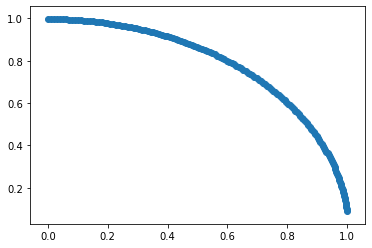

In [136]:
def h(x,y):
    return (x**2+y**2)


def f(x,y):
    return float(math.exp(-x**2-y**2))
def g(x,y):
    return float(math.exp(-(x-1)**2-(y-1)**2))
def h2(x,y):
    return float(2*f(x,y) - 2*g(x,y))
def i(x,y):
    return ((x**2+y**2+2*x))
    
abscisses=simple_contour(h, 1.0)[0]
ordo=simple_contour(h, 1.0)[1]
abscisses, ordo
plt.scatter(abscisses,ordo)

In [146]:
# Rotators
# ------------------------------------------------------------------------------
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise


def rotate_direction(direction, n=1):
    return (direction + n) % 4


def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function


# Complex Contouring
# ------------------------------------------------------------------------------

# Customize the simple_contour function used in contour :
# simple_contour = smart_simple_contour


def contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.01):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append(
                        (xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve)
                    )
    return curves

In [154]:


def f(x,y):
    return float(math.exp(-x**2-y**2))
def g(x,y):
    return float(math.exp(-(x-1)**2-(y-1)**2))
def h2(x,y):
    return float(2*f(x,y) - 2*g(x,y))
def i(x,y):
    return ((x**2+y**2+2*x))


n = len(contour(h2, 0.5))
for k in range (n):
    abscisses = contour(h2, 0.5)[k][0]
    ordo = contour(h2, 0.5)[k][1]
    print(abscisses, ordo)
    plt.scatter(abscisses,ordo)


#plt.scatter(abscisses,ordo)


TypeError: must be real number, not ArrayBox